## Phising Dataset

To collect the dataset, we have deployed multiple agents and soluble agents within an infrastructure with
more than 3k entities, comprising laptops, workstations, and smartphone devices. <br> The methods to build
ground truth are as follows:

- Simulator: We launch different realistic phishing campaigns, aiming to expose user credentials or defeat access to a service.
- IDS: We deploy an IDS to collect various alerts associated with behavioral anomalies, such as cryptomining or peer-to-peer traffic.

For each user exposed to the behaviors stated in the summary table, different TW is computed, aggregating
user behavior within a fixed time interval. <br> This TW serves as the basis for generating various supervised
and unsupervised methods.

## Time window representation 

The time windows (TW) are a data representation based on aggregated logs from multimodal sources between two
timestamps. <br> In this study, logs from HTTP, DNS, SSL, and SMTP are taken into consideration, allowing the
construction of rich behavioral profiles. <br> The indicators described in the TE are a set of manually curated
interpretable features designed to describe device-level properties within the specified time frame.

In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
from modules.lib_IF import *
from modules.lib import *
from modules.optimizer import *
from xai_client import Client
import json


c:\Users\NikolasTheol\anaconda3\envs\xxp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
entity = "desktop" #desktop or smartphone
threat = "phishing_behaviour" 
path_dataset = f'data/Risky Behaviour Datasets/{threat}/min_windows_size_6/{entity}_features.pckl'
seed = 42
dataset = pd.read_pickle(path_dataset)

#### Load and split dataset based on the unique users

In [3]:
from sklearn.model_selection import train_test_split


unique_users = dataset.loc[dataset["label"] != -1, 'user_id'].unique()
# Split user IDs into train_test and validation sets
# We fix validation dataset to be always the same by fixing the random state, the rest changes
users_train_test, users_validation = train_test_split(unique_users, test_size=0.3, random_state=seed)

data_train_test = dataset[dataset['user_id'].isin(users_train_test)]
data_validation_labeled = dataset[dataset['user_id'].isin(users_validation)]


In [4]:
data_train_test = data_train_test.drop(columns=["timestamp", "user_id", "entity"])

In [5]:
data_validation_labeled = data_validation_labeled.drop(columns=["timestamp", "user_id", "entity"])

### Model creation and Training

In [6]:
import numpy as np
cat_columns = data_train_test.select_dtypes(exclude=[np.number]).columns.tolist()
numeric_columns = data_train_test.drop(columns='label').select_dtypes(exclude=['object']).columns.tolist()

In [24]:
numerical_transformer = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer,numeric_columns),
    ])

hyperparameters = {'Model__max_depth': (2, 4, 6, 10),
                                'Model__min_child_weight': (1, 3),
                                'Model__learning_rate': [0.001, 0.01, 0.1],
                                'Model__n_estimators': (25, 50, 75 , 100),
                                "preprocessor__num__scaler": [StandardScaler(), MinMaxScaler(),RobustScaler()]}

ml_pipeline = Pipeline([("preprocessor", preprocessor),
                        ("Model", xgb.XGBClassifier())])

# optimizer = ModelOptimizer(ml_pipeline,param_grid=hyperparameters,optimization_algorithm='grid_search')
# opt = optimizer.optimize(data_train_test.drop(columns='label'),data_train_test.label)

In [7]:
# import itertools
# import time
# from sklearn.metrics import (
#     accuracy_score, precision_score, recall_score, f1_score,
#     confusion_matrix
# )
# param_keys = hyperparameters.keys()
# param_values = hyperparameters.values()
# combinations = list(itertools.product(*param_values))

# # Create an empty list to store results
# results = []
# all_test_results = []

# # Perform the grid search manually
# model_id = 0
# for combination in combinations:
#     print(combination)
#     break
# #     params = dict(zip(param_keys, combination))
    
# #     # Set the parameters to the pipeline
# #     ml_pipeline.set_params(**params)
    
# #     # Record the start time
# #     start_time = time.time()
    
# #     # Fit the model
# #     ml_pipeline.fit(data_train_test.drop(columns='label'), data_train_test.label)
    
# #     # Record the end time
# #     end_time = time.time()
# #     runtime = end_time - start_time
    
# #     # Make predictions
# #     y_pred = ml_pipeline.predict(data_validation_labeled.drop(columns='label'))
    
# #     # Evaluate the model
# #     accuracy = accuracy_score(data_validation_labeled.label, y_pred)
# #     precision = precision_score(data_validation_labeled.label, y_pred, average='binary')
# #     recall = recall_score(data_validation_labeled.label, y_pred, average='binary')
# #     f1 = f1_score(data_validation_labeled.label, y_pred, average='binary')
# #     f1_macro = f1_score(data_validation_labeled.label, y_pred, average='macro')
    
# #     # Compute confusion matrix
# #     tn, fp, fn, tp = confusion_matrix(data_validation_labeled.label, y_pred).ravel()
    
# #     # Record the hyperparameters, performance, runtime, and model ID
# #     result = {
# #         'max_depth': params['Model__max_depth'],
# #         'min_child_weight': params['Model__min_child_weight'],
# #         'learning_rate': params['Model__learning_rate'],
# #         'n_estimators': params['Model__n_estimators'],
# #         'scaler': type(params['preprocessor__num__scaler']).__name__,
# #         'accuracy': accuracy,
# #         'precision': precision,
# #         'recall': recall,
# #         'f1_score': f1,
# #         'f1_macro': f1_macro,
# #         'true_positives': tp,
# #         'false_positives': fp,
# #         'true_negatives': tn,
# #         'false_negatives': fn,
# #         'runtime': runtime,
# #         'id': model_id
# #     }
# #     results.append(result)
    
# #     test_results_df = pd.DataFrame(data_validation_labeled.drop(columns='label'))
# #     test_results_df['label'] = data_validation_labeled.label
# #     test_results_df['prediction'] = y_pred
# #     test_results_df['id'] = model_id
    
# #     # Append the test results to the list
# #     all_test_results.append(test_results_df)
# #     # Increment the model ID
# #     model_id += 1
# #     # if model_id==3:
# #     #     break

# # # Convert the results to a DataFrame
# # results_df = pd.DataFrame(results)

In [8]:
import joblib

opt = joblib.load('metadata/proxy_data_models/phising_fullgrid.pkl')

In [9]:
query = pd.DataFrame.from_dict(opt.best_params_,orient='index').T

In [10]:
# import joblib


# joblib.dump(opt, 'phising_fullgrid.pkl')

Accuracy Score is 0.647415329768271


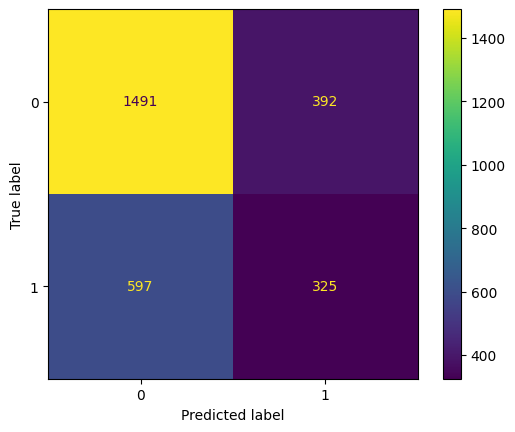

In [11]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

test = data_validation_labeled.drop(columns='label')
test_labels = data_validation_labeled.label
best_model = opt.best_estimator_
pred_y_test = best_model.predict(test)

print(f'Accuracy Score is {accuracy_score(test_labels,pred_y_test)}')
cm = confusion_matrix(test_labels, pred_y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

In [12]:
cm = pd.DataFrame(cm, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])

In [13]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, pred_y_test))

              precision    recall  f1-score   support

           0       0.71      0.79      0.75      1883
           1       0.45      0.35      0.40       922

    accuracy                           0.65      2805
   macro avg       0.58      0.57      0.57      2805
weighted avg       0.63      0.65      0.63      2805



In [14]:
classification_report = pd.DataFrame(classification_report(test_labels, pred_y_test,output_dict=True)).transpose()

## Proxy Model creation for PDP-ALE and Counterfactual Explanations

In [15]:
hyperparameters = {'Model__max_depth': (2, 4, 6, 10),
                                'Model__min_child_weight': (1, 3),
                                'Model__learning_rate': [0.001, 0.01, 0.1],
                                'Model__n_estimators': (25, 50, 75 , 100),
                                "preprocessor__num__scaler": [StandardScaler(), MinMaxScaler(),RobustScaler()]}

In [16]:
    # proxy model for PDP-ALE
surrogate_model_accuracy = proxy_model(opt.param_grid,opt,'accuracy','XGBoostRegressor')

In [17]:
# missclassified = pd.concat([test, test_labels.rename('GroundTruth')], axis=1).reset_index(drop=True)
# missclassified['Predicted'] = pred_y_test
# missclassified['Label'] = (missclassified['GroundTruth'] != missclassified['Predicted']).astype(int)
# missclassified[missclassified['Label']==1]

In [18]:
# missclassified[missclassified['Label']==1].drop(columns='Label').to_csv('misclassified_instances.csv')

In [19]:
# missclassified[missclassified['Label']==1].drop(columns='Label')

In [20]:
missclassified_instances = pd.read_csv('Real_I2Cat_missclassified_instances.csv',index_col=0)
# misclassified_instance = missclassified.drop(columns=['GroundTruth','Label']).loc[5]
# train = data_train_test.drop(columns='label')
# train_labels = data_train_test.label
# #proxy_model and dataset for counterfactual explanations
# proxy_model , proxy_dataset = instance_proxy(train,train_labels,opt, misclassified_instance,hyperparameters)

In [21]:
missclassified_instance = missclassified_instances[missclassified_instances.id==21].reset_index(drop=True).loc[3].to_dict()

In [21]:
query = pd.DataFrame.from_dict(opt.best_params_,orient='index').T


## Create gRPC Client

### Run `python xai_server.py` command on terminal in order to start server

### Compute PDP 1D Plots via gRPC

In [23]:
client = Client()
k = client.get_explanations(explanation_type='hyperparameterExplanation',explanation_method='pdp',model='I2Cat_Phising_model',feature1='Model__learning_rate')

### Compute PDP 2D Plots via gRPC

In [24]:
client = Client()
explainability_type,explanation_method,explainability_model,plot_name,plot_descr,plot_type,features,xAxis,yAxis,zAxis= client.get_explanations(explanation_type='hyperparameterExplanation',explanation_method='2dpdp',model='I2Cat_Phising_model',feature1='Model__min_child_weight',feature2='Model__max_depth')

### Compute ALE Plots via gRPC

In [25]:
client = Client()
explainability_type,explanation_method,explainability_model,plot_name,plot_descr,plot_type,features,xAxis,yAxis = client.get_explanations(explanation_type='hyperparameterExplanation',explanation_method='ale',model='I2Cat_Phising_model',feature1='Model__max_depth')

### Counterfactual Explanations via gRPC

In [26]:
client = Client()
explainability_type,explanation_method,explainability_model,plot_name,plot_descr,plot_type,table_contets = client.get_explanations(explanation_type='hyperparameterExplanation',explanation_method='counterfactuals',model='I2Cat_Phising_model')

## Model Explainability

### PDPlots and 2D PDPlots via gRPC

In [27]:
client = Client()
explainability_type,explanation_method,explainability_model,plot_name,plot_descr,plot_type,features,xAxis,yAxis,zAxis = client.get_explanations(explanation_type='featureExplanation',explanation_method='pdp',
                                                  model = 'I2Cat_Phising_model',model_id=256, feature1='dns_interlog_time_q1')



## CounterfactualsExplanations via gRPC

In [26]:
client = Client()
explainability_type,explanation_method,explainability_model,plot_name,plot_descr,plot_type,table_contents = client.get_explanations(explanation_type='featureExplanation',explanation_method='counterfactuals',query=str(missclassified_instance),model='I2Cat_Phising_model',model_id = 10,target='label')

### ALE plots via gRPC

In [27]:
client = Client()
explainability_type,explanation_method,explainability_model,plot_name,plot_descr,plot_type,features,xAxis,yAxis = client.get_explanations(explanation_type='featureExplanation',explanation_method='ale',
                                                  model = 'I2Cat_Phising_model', model_id=21, feature1='dns_interlog_time_q1')

In [23]:
from sklearn.inspection import partial_dependence
features = 'dns_interlog_time_q1'
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
print(features)
print([train.columns.tolist().index(features)])
numeric_features = train.select_dtypes(include=numerics).columns.tolist()
categorical_features = train.columns.drop(numeric_features)

pdp = partial_dependence(opt, train, features = [train.columns.tolist().index(features)],
                        feature_names=train.columns.tolist(),categorical_features=categorical_features)

dns_interlog_time_q1
[0]


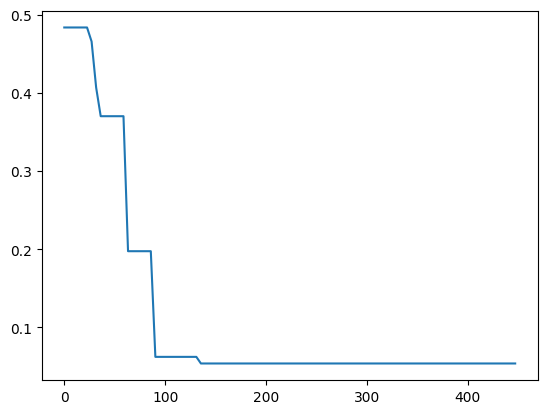

In [29]:
import matplotlib.pyplot as plt
plt.plot(pdp['grid_values'][0],pdp['average'][0])

In [68]:
from skopt.plots import _evenly_sample
from scipy.stats.mstats import mquantiles
percentiles=(0.05, 0.95)
def partial_dependence_1D(categorical_features, model, i, samples,
                          n_points=100):
    """
    Calculate the partial dependence for a single dimension.

    This uses the given model to calculate the average objective value
    for all the samples, where the given dimension is fixed at
    regular intervals between its bounds.

    This shows how the given dimension affects the objective value
    when the influence of all other dimensions are averaged out.

    Parameters
    ----------
    space : `Space`
        The parameter space over which the minimization was performed.

    model
        Surrogate model for the objective function.

    i : int
        The dimension for which to calculate the partial dependence.

    samples : np.array, shape=(n_points, n_dims)
        Randomly sampled and transformed points to use when averaging
        the model function at each of the `n_points` when using partial
        dependence.

    n_points : int, default=40
        Number of points at which to evaluate the partial dependence
        along each dimension `i`.

    Returns
    -------
    xi : np.array
        The points at which the partial dependence was evaluated.

    yi : np.array
        The average value of the modelled objective function at
        each point `xi`.

    """
    # The idea is to step through one dimension, evaluating the model with
    # that dimension fixed and averaging either over random values or over
    # the given ones in x_val in all other dimensions.
    # (Or step through 2 dimensions when i and j are given.)
    # Categorical dimensions make this interesting, because they are one-
    # hot-encoded, so there is a one-to-many mapping of input dimensions
    # to transformed (model) dimensions.

    # dim_locs[i] is the (column index of the) start of dim i in
    # sample_points.
    # This is usefull when we are using one hot encoding, i.e using
    # categorical values

    def _calc(x):
        """
        Helper-function to calculate the average predicted
        objective value for the given model, when setting
        the index'th dimension of the search-space to the value x,
        and then averaging over all samples.
        """
        rvs_ = samples.copy(deep=True) # copy
        # We replace the values in the dimension that we want to keep
        # fixed
        rvs_[i] = x
        # In case of `x_eval=None` rvs conists of random samples.
        # Calculating the mean of these samples is how partial dependence
        # is implemented.
        return np.mean(model.predict(rvs_).astype(float))
    
    if i in categorical_features:
        xi = np.array(samples[i].unique())
    else:
        if samples[i].nunique() <= n_points:
            xi = np.sort(samples[i].unique())
        else:
            emp_percentiles = mquantiles(samples[i], prob=list([0.05,0.95]), axis=0
            )
            xi =np.linspace(
                emp_percentiles[0],
                emp_percentiles[1],
                num=100,
                endpoint=True,
            )    # Calculate the partial dependence for all the points.
    yi = [_calc(x) for x in xi]

    return xi, yi

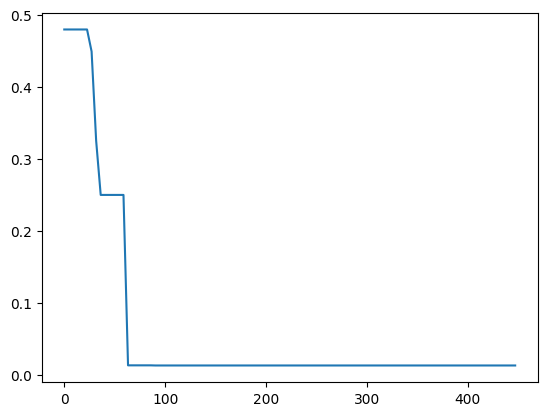

In [70]:
import matplotlib.pyplot as plt
plt.plot(x,y)

In [69]:
x,y = partial_dependence_1D(categorical_features, opt, 'dns_interlog_time_q1', train,
                          n_points=100)

In [74]:
import grpc
import xai_service_pb2
import xai_service_pb2_grpc

with grpc.insecure_channel('localhost:50051') as channel:
    stub = xai_service_pb2_grpc.ExplanationsStub(channel)
    k = stub.Initialization(xai_service_pb2.InitializationRequest(model_name = 'I2Cat_Phising_model'))

In [28]:
import grpc
import xai_service_pb2
import xai_service_pb2_grpc

with grpc.insecure_channel('localhost:50051') as channel:
    stub = xai_service_pb2_grpc.ExplanationsStub(channel)
    k = stub.ModelAnalysisTask(xai_service_pb2.ModelAnalysisTaskRequest(model_name = 'I2Cat_Phising_model',model_id=258))

In [29]:
k.feature_explanation.plots

{'pdp': explainability_type: "featureExplanation"
explanation_method: "pdp"
explainability_model: "I2Cat_Phising_model"
plot_name: "Partial Dependence Plot (PDP)"
plot_descr: "PD (Partial Dependence) Plots show how a feature affects a model\'s predictions, holding other features constant, to illustrate feature impact."
plot_type: "LinePLot"
features {
  feature1: "dns_interlog_time_q1"
}
xAxis {
  axis_name: "dns_interlog_time_q1"
  axis_values: "0.0"
  axis_values: "4.515151515151516"
  axis_values: "9.030303030303031"
  axis_values: "13.545454545454547"
  axis_values: "18.060606060606062"
  axis_values: "22.575757575757578"
  axis_values: "27.090909090909093"
  axis_values: "31.60606060606061"
  axis_values: "36.121212121212125"
  axis_values: "40.63636363636364"
  axis_values: "45.151515151515156"
  axis_values: "49.66666666666667"
  axis_values: "54.18181818181819"
  axis_values: "58.6969696969697"
  axis_values: "63.21212121212122"
  axis_values: "67.72727272727273"
  axis_values:

In [23]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

from aix360.algorithms.protodash import ProtodashExplainer

test['predictions'] = test_labels
test.reset_index(drop=True,inplace=True)
train['label'] = train_labels

In [24]:
explainer = ProtodashExplainer()

reference_set_train = train[train.label==0].drop(columns='label')

x=0
# for index,row in test.iterrows():
row = test.loc[7]
prediction =row.predictions
print("Query Instance")
display(row.to_frame().T)
try:
    (W, S, _)= explainer.explain(np.array(row.to_frame().T.drop(columns='predictions')).reshape(1,-1),np.array(reference_set_train),m=5)
except Exception as error:
# handle the exception
    print("An exception occurred:", error)



prototypes = train[train.label==0].reset_index(drop=True).iloc[S, :].copy()
# Compute normalized importance weights for prototypes
prototypes["Weights of Prototypes"] = np.around(W/np.sum(W), 2) 
print('Prototypes')
display(prototypes)
proto_preds_train = list(opt.predict(prototypes.drop(columns='Weights of Prototypes')))
i=0
for p in proto_preds_train:
    if p == prediction:
        i=i+1

print(f"{i} out of {len(prototypes)} have the same prediction as the test instance")
    # if x==10:
    #     break
    # else:
    #     x=x+1
    

Query Instance


,dns_interlog_time_q1,dns_interlog_time_q2,dns_interlog_time_q3,dns_interlog_time_q4,dns_interlog_time_q5,ssl_interlog_time_q1,ssl_interlog_time_q2,ssl_interlog_time_q3,ssl_interlog_time_q4,ssl_interlog_time_q5,...,smtp_in_is_spam,smtp_in_files,smtp_in_hazardous_extensions,non_working_days_dns,non_working_days_http,non_working_days_ssl,non_working_hours_dns,non_working_hours_http,non_working_hours_ssl,predictions
7,21.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Prototypes


,dns_interlog_time_q1,dns_interlog_time_q2,dns_interlog_time_q3,dns_interlog_time_q4,dns_interlog_time_q5,ssl_interlog_time_q1,ssl_interlog_time_q2,ssl_interlog_time_q3,ssl_interlog_time_q4,ssl_interlog_time_q5,...,smtp_in_files,smtp_in_hazardous_extensions,non_working_days_dns,non_working_days_http,non_working_days_ssl,non_working_hours_dns,non_working_hours_http,non_working_hours_ssl,label,Weights of Prototypes
666,207.0,0.0,0.0,0.0,0.0,59.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.13
2424,7.0,0.0,0.0,0.0,0.0,139.0,3.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.03
3,3.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.68
432,454.0,0.0,0.0,0.0,0.0,24.0,3.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0,0.03
764,411.0,0.0,0.0,0.0,0.0,1435.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.13


5 out of 5 have the same prediction as the test instance


In [25]:
explainer = ProtodashExplainer()

reference_set_train = train[train.label==0].drop(columns='label')

(W, S, _)= explainer.explain(np.array(test.loc[7].to_frame().T.drop(columns='predictions')).reshape(1,-1),np.array(reference_set_train),m=5)

In [26]:
prototypes = reference_set_train.reset_index(drop=True).iloc[S, :].copy()
prototypes["Weights of Prototypes"] = np.around(W/np.sum(W), 2) 

In [27]:
prototypes

,dns_interlog_time_q1,dns_interlog_time_q2,dns_interlog_time_q3,dns_interlog_time_q4,dns_interlog_time_q5,ssl_interlog_time_q1,ssl_interlog_time_q2,ssl_interlog_time_q3,ssl_interlog_time_q4,ssl_interlog_time_q5,...,smtp_in_is_spam,smtp_in_files,smtp_in_hazardous_extensions,non_working_days_dns,non_working_days_http,non_working_days_ssl,non_working_hours_dns,non_working_hours_http,non_working_hours_ssl,Weights of Prototypes
666,207.0,0.0,0.0,0.0,0.0,59.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.13
2424,7.0,0.0,0.0,0.0,0.0,139.0,3.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03
3,3.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.68
432,454.0,0.0,0.0,0.0,0.0,24.0,3.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.03
764,411.0,0.0,0.0,0.0,0.0,1435.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.13


In [28]:
X = np.array(test.loc[7].to_frame().T.drop(columns='predictions')).reshape(1,-1)
z = np.array(reference_set_train)[S, 0:] # Store the prototypes
eps = 1e-10 # Small constant to guard against divide by zero errors
fwt = np.zeros(z.shape)
for i in range (z.shape[0]): # Compute feature similarity for each prototype
    for j in range(z.shape[1]):
        fwt[i, j] = np.exp(-1 * abs(X[0, j] - z[i,j])/(np.std(z[:, j])+eps))
                
# move wts to a dataframe to display
dfw = pd.DataFrame.from_records(np.around(fwt.astype('double'), 2))
dfw.columns = test.columns[:-1]
dfw.transpose()

,0,1,2,3,4
dns_interlog_time_q1,0.38,0.93,0.91,0.10,0.13
dns_interlog_time_q2,1.00,1.00,1.00,1.00,1.00
dns_interlog_time_q3,1.00,1.00,1.00,1.00,1.00
dns_interlog_time_q4,1.00,1.00,1.00,1.00,1.00
dns_interlog_time_q5,1.00,1.00,1.00,1.00,1.00
...,...,...,...,...,...
non_working_days_http,1.00,1.00,1.00,1.00,1.00
non_working_days_ssl,1.00,1.00,1.00,1.00,1.00
non_working_hours_dns,1.00,1.00,1.00,0.08,1.00
non_working_hours_http,1.00,1.00,1.00,0.08,1.00


In [29]:
def determine_classification(row):
    if row['GroundTruth'] == 1 and row['Predicted'] == 1:
        return 'tp'
    elif row['GroundTruth'] == 0 and row['Predicted'] == 0:
        return 'tn'
    elif row['GroundTruth'] == 0 and row['Predicted'] == 1:
        return 'fp'
    elif row['GroundTruth'] == 1 and row['Predicted'] == 0:
        return 'fn'

# Apply the function to each row to create the new column
missclassified['classification'] = missclassified.apply(determine_classification, axis=1)

In [30]:
missclassified.drop(columns=['GroundTruth','Predicted','Label'],inplace=True)

In [31]:
import umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(missclassified.drop(columns='classification'))


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in missclassified.classification.map({"tp":0, "tn":1, "fp":2,'fn':3})])


NameError: name 'embedding' is not defined

In [36]:
[sns.color_palette()[x] for x in missclassified.classification.map({"TP":'tp', "TN":'tn', "FP":'fp','FN':'fn'})]

TypeError: list indices must be integers or slices, not float